In [1]:
import optuna
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image
from sklearn.manifold import TSNE
import random

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.models as models
from torch.nn.parallel import DataParallel
from torchvision.transforms import ToTensor
from torchvision import transforms
import torchvision.utils as vutils
import torch.optim as optim
from torchinfo import summary

torch.manual_seed(6)
random.seed(80)

In [2]:
class ClassifierDataset(Dataset):
    def __init__(self, root_dir, betti_num=0, transform=None):
        self.root_dir = root_dir
        self.bettinum= betti_num
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.labels = []
        self.subjids = []
        self.samples = []
        label_dict = {'EMCI': 0, 'LMCI': 1}

        for class_name in label_dict.keys():
                    class_dir = os.path.join(root_dir, class_name)
                    for file_name in os.listdir(class_dir):
                        if file_name.endswith("h2.csv"):
                            paths = [os.path.join(class_dir, file_name.replace("h2.csv", f"h{i}.csv")) for i in range(3)]
                            if all(os.path.exists(path) for path in paths):
                                subj_id = file_name[:-11] #sub_allnetworksnew-24    
                                self.samples.append((paths, label_dict[class_name], subj_id))
                                self.labels.append(label_dict[class_name])
                                self.subjids.append(subj_id)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        paths, label, subjid= self.samples[idx]
        images = []

        for path in paths:
            data = torch.Tensor(np.array(pd.read_csv(path).drop('Unnamed: 0',axis=1))).unsqueeze(0)
            mean = torch.mean(data)
            std = torch.std(data)
            standardize_transform = transforms.Normalize(mean=mean, std=std)
            normalized_data = standardize_transform(data)
            images.append(normalized_data)
            
        combined_image = torch.stack(images, dim=1)

        if self.transform:
            image = self.transform(combined_image)
        else:
            image = combined_image
        return images[self.bettinum], (label, subjid)

In [3]:
data = ClassifierDataset('/kaggle/input/persis-dataset-csv/ADNI_4CLASS/DMN/',betti_num=2)

torch.Size([1, 34, 34])


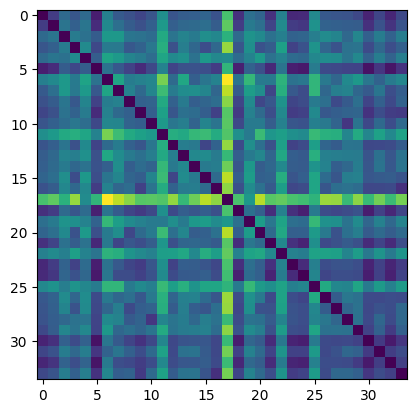

In [4]:
for i,j in data:
    print(i.shape)
    plt.imshow(i[0])
    break

In [5]:
import torch
import torch.nn as nn

class YourModel(nn.Module):
    def __init__(self, rois):
        super(YourModel, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU(inplace=True)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU(inplace=True)
        self.gvp = nn.AdaptiveAvgPool2d(1)

        # Linear layer for x_linear
        self.parallel = nn.Linear(1*rois*rois, 256)
        
        # Concatenated linear layer
        self.fc1 = nn.Linear(256 + 256, 128)  # Concatenate 256 from gvp and 256 from parallel
        self.dropout = nn.Dropout(0.2, inplace=True)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x_in):
        x = self.conv1(x_in)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.gvp(x)
        x_gap = x.view(x.size(0), -1)
        x_linear = x_in.view(x_in.size(0), -1)
        x_parallel = self.parallel(x_linear)
        x_stacked = torch.cat((x_gap, x_parallel), dim=1)
        x = self.fc1(x_stacked)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [6]:
networks = {
    'CB': 18,
    'CO':32,
    'DMN':34,
    'FP':21,
    'OP': 22,
    'SM':33
}

for network, rois in networks.items():
    print(f'%%%%%%%%%%%%%%%%%%%%%%%     {network}   %%%%%%%%%%%%%%%%%%%%%%%')
    for bettidecriptor in range(3):
        print(f'%%%%%%%%%%%%%%%%%%%%%%%     Betti : {bettidecriptor}   %%%%%%%%%%%%%%%%%%%%%%%')
        dataset_path = f'/kaggle/input/persis-dataset-csv/ADNI_4CLASS/{network}'
        custom_dataset = ClassifierDataset(root_dir=dataset_path,betti_num=bettidecriptor)
        test_size = int(len(custom_dataset) * 0.2)
        train_size = len(custom_dataset) - test_size
        train_ds, test_ds = random_split(custom_dataset, [train_size, test_size])
        train_dl = DataLoader(train_ds, batch_size=64)
        test_dl = DataLoader(test_ds, batch_size=64)

        #%%%%%%%%%%%%%%%%%%%%%%%     DENSE NET MODEL   %%%%%%%%%%%%%%%%%%%%%%%
        model = YourModel(rois)

        #%%%%%%%%%%%%%%%%%%%%%%%     HYPERPARAMETERS   %%%%%%%%%%%%%%%%%%%%%%%
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        model = DataParallel(model)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 50

        #%%%%%%%%%%%%%%%%%%%%%%%     MODEL TRAINING   %%%%%%%%%%%%%%%%%%%%%%%

        train_losses = []
        val_losses = []
        train_accu = []
        val_accu = []

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0

            for inputs, labels_ in train_dl:
                inputs = inputs.to(device)
                labels = labels_[0].to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

                train_loss += loss.item()
            train_accuracy = 100 * train_correct / train_total

            # Validation phase
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for inputs, labels_ in test_dl:
                    inputs = inputs.to(device)
                    labels = labels_[0].to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            val_accuracy = 100 * val_correct / val_total
            val_loss /= len(test_dl)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accu.append(train_accuracy)
            val_accu.append(val_accuracy)

            print(f"Epoch [{epoch+1}/{num_epochs}]: "
                  f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
                  f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        epochs = list(range(1, len(train_losses) + 1))

        plt.plot(epochs, train_losses, marker='o')
        plt.title('Training Loss Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig(f'{network}training_loss_curve.png')
        plt.close()

        plt.plot(epochs, train_accu, marker='o')
        plt.title('Traning and Validation Accuracy Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy in %')
        plt.ylim(0,120)
        plt.savefig(f'{network}accuracy_curve.png')
        plt.close()

%%%%%%%%%%%%%%%%%%%%%%%     CB   %%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%     Betti : 0   %%%%%%%%%%%%%%%%%%%%%%%
Epoch [1/50]: Train Loss: 2.8791, Train Accuracy: 55.56%, Val Loss: 0.7162, Val Accuracy: 53.33%
Epoch [2/50]: Train Loss: 2.2932, Train Accuracy: 70.37%, Val Loss: 0.6835, Val Accuracy: 63.33%
Epoch [3/50]: Train Loss: 2.0508, Train Accuracy: 76.54%, Val Loss: 0.6916, Val Accuracy: 68.33%
Epoch [4/50]: Train Loss: 1.7497, Train Accuracy: 82.30%, Val Loss: 0.7170, Val Accuracy: 70.00%
Epoch [5/50]: Train Loss: 1.5421, Train Accuracy: 82.72%, Val Loss: 0.7821, Val Accuracy: 65.00%
Epoch [6/50]: Train Loss: 1.2964, Train Accuracy: 85.60%, Val Loss: 0.8730, Val Accuracy: 63.33%
Epoch [7/50]: Train Loss: 1.1563, Train Accuracy: 86.83%, Val Loss: 0.9666, Val Accuracy: 68.33%
Epoch [8/50]: Train Loss: 1.0198, Train Accuracy: 89.30%, Val Loss: 1.0775, Val Accuracy: 66.67%
Epoch [9/50]: Train Loss: 0.9367, Train Accuracy: 90.53%, Val Loss: 1.1693, Val Accuracy: 66.67%
Epoch 